In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import LinearRegression

from matplotlib import gridspec
import scipy.stats as stats

from scipy.stats import kstest, cramervonmises
import tensorflow as tf
import tensorflow_probability as tfp
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
import time

from ipcc_colormap import *
from utils import *


import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Myriad Pro'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600

coastline = gpd.read_file('/home/mizu_home/xp53/nas/home/coastlines-split-SGregion/lines.shp')
mask = np.loadtxt('mask.txt')

ipcc_blue = (112.0/255, 160.0/255, 205.0/255, 1.0)
ipcc_orange = (196.0/255, 121.0/255, 0.0/255, 1.0)

tmp_cmap = ipcc_cmap()
tmp_cmap.read_rgb_data_from_excel()
;

In [ ]:
# DATA PREPARATION
# the station-based rainfall data is already organized in a N by P matrix
rain_obs = np.loadtxt('data/sta_monthly.csv')

# the simulated rainfall data is reshaped to a 2d matrix of size N by (W x L)
rain_sim_flatten = np.loadtxt('data/wrf_monthly.csv')
rain_sim = rain_sim_flatten.reshape(rain_sim_flatten.shape[0], 120, 160)

# sim_sel constains a P by 4 matrix
# the first two columns are the row and column indices of grids corresponding to the stations
# the last two columns are the lons and lats of grids corresponding to the stations
sim_sel = np.loadtxt('data/wrf_loc.csv')
sim_idx = sim_sel[:, :2].astype(int)

# select simulated rainfall at stations
wrf_sta = np.array([rain_sim[:, i, j] for (i, j) in sim_idx]).T

# lats and lons of all grids are stored in a 2d matrix of 2 by (W x L)
# the first row is lons and the second row is lats
longlat = np.loadtxt('data/lonlat.txt')
lons = longlat[0, :].reshape(120, 160)
lats = longlat[1, :].reshape(120, 160)

# read station lons (3rd column) and lats (4th column)
sta_loc = np.genfromtxt('data/sta_lookup_new.csv', delimiter=',')[:, 2:]


In [ ]:
# a two-stage interpolation (suggested by my colleague in NUS, Chen ZHAO)
# Stage 1: GP estimation using mus and sigmas learned from historical simulations
# the MAP estimates of GP inferences are used as the best estimates to yield residuals
# such residuals can be regarded as a combination of systematic model biases and internal climate variability
# by assuming some underlying spatially homogeneous patterns of the model biases
# Stage 2: the residuals are interpolated using the OK method
# this section uses a leave-one-out cross validation to evaluate the performance of the two-stage interpolation

# Initialize the GP interpolator
tmp = gp_interpolator(P = sim_idx.shape[0] - 1)
kge0 = np.zeros((12, tmp.p_ + 1))
kge1 = np.zeros((12, tmp.p_ + 1))
kge2 = np.zeros((12, tmp.p_ + 1))
ks_statistic = np.zeros((12, tmp.p_ + 1))

r1 = np.zeros((480, sim_idx.shape[0]))
r2 = np.zeros((480, sim_idx.shape[0]))

for i in range(12):
    xx_obs = rain_obs[i::12, :]
    xx_sim = wrf_sta[i::12, :]
    t1 = time.time()
    for j in range(tmp.p_ + 1):
        txx_obs = np.delete(xx_obs, j, axis = 1)
        txx_sim = np.delete(xx_sim, j, axis = 1)
        txx_loc = np.delete(sta_loc, j, axis = 0)
        
        tmp.read_rainfall(obs = txx_obs, sim = txx_sim)
        tmp.sn_converge()
        yy_sim = xx_sim[:, j][:, None]
        yy_obs = xx_obs[:, j][:, None]

        y1, _ = tmp.predict(yy_sim)
        x1, _ = tmp.predict(txx_sim)

        ex = txx_obs - x1.T
        y2 = np.zeros(y1.shape)
        for k in range(ex.shape[0]):
            tdata = np.concatenate((txx_loc, ex[k, :][:, None]), axis = 1)
            OK = OrdinaryKriging(
                tdata[:, 0], tdata[:, 1], tdata[:, 2],
                variogram_model = 'gaussian'
            )
            ey, _ = OK.execute('points', sta_loc[j, 0], sta_loc[j, 1])
            y2[k] = y1[k] + ey
        y1[y1<0] = 0
        y2[y2<0] = 0  
        kge0[i, j] = kge(yy_obs.squeeze(), yy_sim.squeeze())
        kge1[i, j] = kge(yy_obs.squeeze(), y1.squeeze())
        kge2[i, j] = kge(yy_obs.squeeze(), y2.squeeze())

        z_reeval = stats.norm.cdf(yy_obs.squeeze(), loc = np.mean(yy_sim), scale = np.std(yy_sim, ddof=1))
        res = kstest(np.sort(z_reeval), 'uniform')
        ks_statistic[i, j] = res.statistic

        r1[i::12, j] = y1.squeeze()
        r2[i::12, j] = y2.squeeze()
    print('Month %d: %.2f seconds' % (i + 1, time.time() - t1))


In [ ]:
kge_kriging = np.loadtxt('kriging_kge.csv')
# the KGE boxplot
fig, ax = plt.subplots(1, 1, figsize = (6, 3))
# plot the kge0 boxplot at positions of x with filler color of red
bp1 = ax.boxplot(kge1.T, positions = np.arange(12) - 0.1, widths = 0.15,
           patch_artist = True, boxprops=dict(facecolor=ipcc_orange), medianprops=dict(color="black"))
bp2 = ax.boxplot(kge2.T, positions = np.arange(12) + 0.1, widths = 0.15,
           patch_artist = True, boxprops=dict(facecolor=ipcc_blue), medianprops=dict(color="black"))
bp3 = ax.scatter(np.arange(12) + 0.1, np.median(kge_kriging.T, axis = 0), s = 15, marker = '^', color = 'limegreen', zorder = 10)
bp4 = ax.scatter(np.arange(12) - 0.1, np.median(kge0.T, axis = 0), s = 15, marker = 'D', color = 'black', zorder = 10)

# ax.axline((0, 0), (11, 0), color = 'black', linestyle = '--')
ax.set_xticks(np.arange(12))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('KGE')
ax.set_ylim([-0.5, 1])
ax.set_yticks([-0.5, 0, 0.5, 1])
# set minor ticks on y axis with an interval of 0.25
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.25))
ax.grid(which = 'both', axis = 'y', linestyle = '--')
# Place the legend horizontally above the plot
handles = [bp1["boxes"][0], bp2["boxes"][0], bp3, bp4]
labels = ['WRF-GP', 'WRF-GP + Kriging', 'Kriging', 'Raw']
ax.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.15), fontsize=10, frameon=False)

np.sum((kge2 >= kge_kriging), axis = 1) / 14
fig.savefig('figures_two_stage/kge_boxplot.png', dpi = 600, bbox_inches = 'tight')


In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (6, 3))
bp = ax.boxplot(ks_statistic.T, positions = np.arange(12), widths = 0.3)
ax.set_xticks(np.arange(12))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('K-S Statistic')
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
# set minor ticks on y axis with an interval of 0.25
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.2))
ax.grid(which = 'both', axis = 'y', linestyle = '--')
fig.savefig('figures_two_stage/ks_statistic.png', dpi = 600, bbox_inches = 'tight')


In [ ]:
# bias correction is first applied to the raw simulations
wrf_sta_bc = np.zeros(wrf_sta.shape)
for i in range(12):
    for j in range(14): 
        tmpxx = np.sort(wrf_sta[i::12, j])
        tmpyy = np.sort(rain_obs[i::12, j])
        lm = stats.linregress(tmpxx, tmpyy)
        wrf_sta_bc[i::12, j] = lm.slope * wrf_sta[i::12, j] + lm.intercept
        # wrf_sta_bc[i::12, j] = tmpxx + np.mean(tmpyy) - np.mean(tmpxx)

# Initialize the GP interpolator
tmp = gp_interpolator(P = sim_idx.shape[0] - 1)
kge0_bc = np.zeros((12, tmp.p_ + 1))
kge1_bc = np.zeros((12, tmp.p_ + 1))
kge2_bc = np.zeros((12, tmp.p_ + 1))


for i in range(12):
    xx_obs = rain_obs[i::12, :]
    xx_sim = wrf_sta_bc[i::12, :]
    t1 = time.time()
    for j in range(tmp.p_ + 1):
        txx_obs = np.delete(xx_obs, j, axis = 1)
        txx_sim = np.delete(xx_sim, j, axis = 1)
        txx_loc = np.delete(sta_loc, j, axis = 0)
        
        tmp.read_rainfall(obs = txx_obs, sim = txx_sim)
        tmp.sn_converge()
        yy_sim = xx_sim[:, j][:, None]
        yy_obs = xx_obs[:, j][:, None]

        y1, _ = tmp.predict(yy_sim)
        x1, _ = tmp.predict(txx_sim)

        ex = txx_obs - x1.T
        y2 = np.zeros(y1.shape)
        for k in range(ex.shape[0]):
            tdata = np.concatenate((txx_loc, ex[k, :][:, None]), axis = 1)
            OK = OrdinaryKriging(
                tdata[:, 0], tdata[:, 1], tdata[:, 2],
                variogram_model = 'gaussian'
            )
            ey, _ = OK.execute('points', sta_loc[j, 0], sta_loc[j, 1])
            y2[k] = y1[k] + ey
        y1[y1<0] = 0
        y2[y2<0] = 0 
        kge0_bc[i, j] = kge(yy_obs.squeeze(), yy_sim.squeeze())
        kge1_bc[i, j] = kge(yy_obs.squeeze(), y1.squeeze())
        kge2_bc[i, j] = kge(yy_obs.squeeze(), y2.squeeze())
    print('Month %d: %.2f seconds' % (i + 1, time.time() - t1))


In [ ]:
# for plotting bias corrected KGE (approximate of upper bound)
kge_kriging = np.loadtxt('kriging_kge.csv')
# the KGE boxplot
fig, ax = plt.subplots(1, 1, figsize = (6, 3))
# plot the kge0 boxplot at positions of x with filler color of red
bp1 = ax.boxplot(kge1_bc.T, positions = np.arange(12) - 0.1, widths = 0.15,
           patch_artist = True, boxprops=dict(facecolor=ipcc_orange), medianprops=dict(color="black"))
bp2 = ax.boxplot(kge2_bc.T, positions = np.arange(12) + 0.1, widths = 0.15,
           patch_artist = True, boxprops=dict(facecolor=ipcc_blue), medianprops=dict(color="black"))
bp3 = ax.scatter(np.arange(12) + 0.1, np.median(kge_kriging.T, axis = 0), s = 15, marker = '^', color = 'limegreen', zorder = 10)
bp4 = ax.scatter(np.arange(12) - 0.1, np.median(kge0_bc.T, axis = 0), s = 15, marker = 'D', color = 'black', zorder = 10)

# ax.axline((0, 0), (11, 0), color = 'black', linestyle = '--')
ax.set_xticks(np.arange(12))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('KGE')
ax.set_ylim([-0.5, 1])
ax.set_yticks([-0.5, 0, 0.5, 1])
# set minor ticks on y axis with an interval of 0.25
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.25))
ax.grid(which = 'both', axis = 'y', linestyle = '--')
# Place the legend horizontally above the plot
handles = [bp1["boxes"][0], bp2["boxes"][0], bp3, bp4]
labels = ['WRF-GP', 'WRF-GP + Kriging', 'Kriging', 'Raw']
ax.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.15), fontsize=10, frameon=False)

fig.savefig('figures_two_stage/kge_boxplot_bc.png', dpi = 600, bbox_inches = 'tight')
np.sum((kge2_bc >= kge_kriging), axis = 1) / 14


[0.58759676]
[0.32316892764295924, 0.568479487442563]
[0.70053509]
[0.40747152641948614, 0.6383349641211001]
[0.51967232]
[0.4053079287031296, 0.6366379887370291]


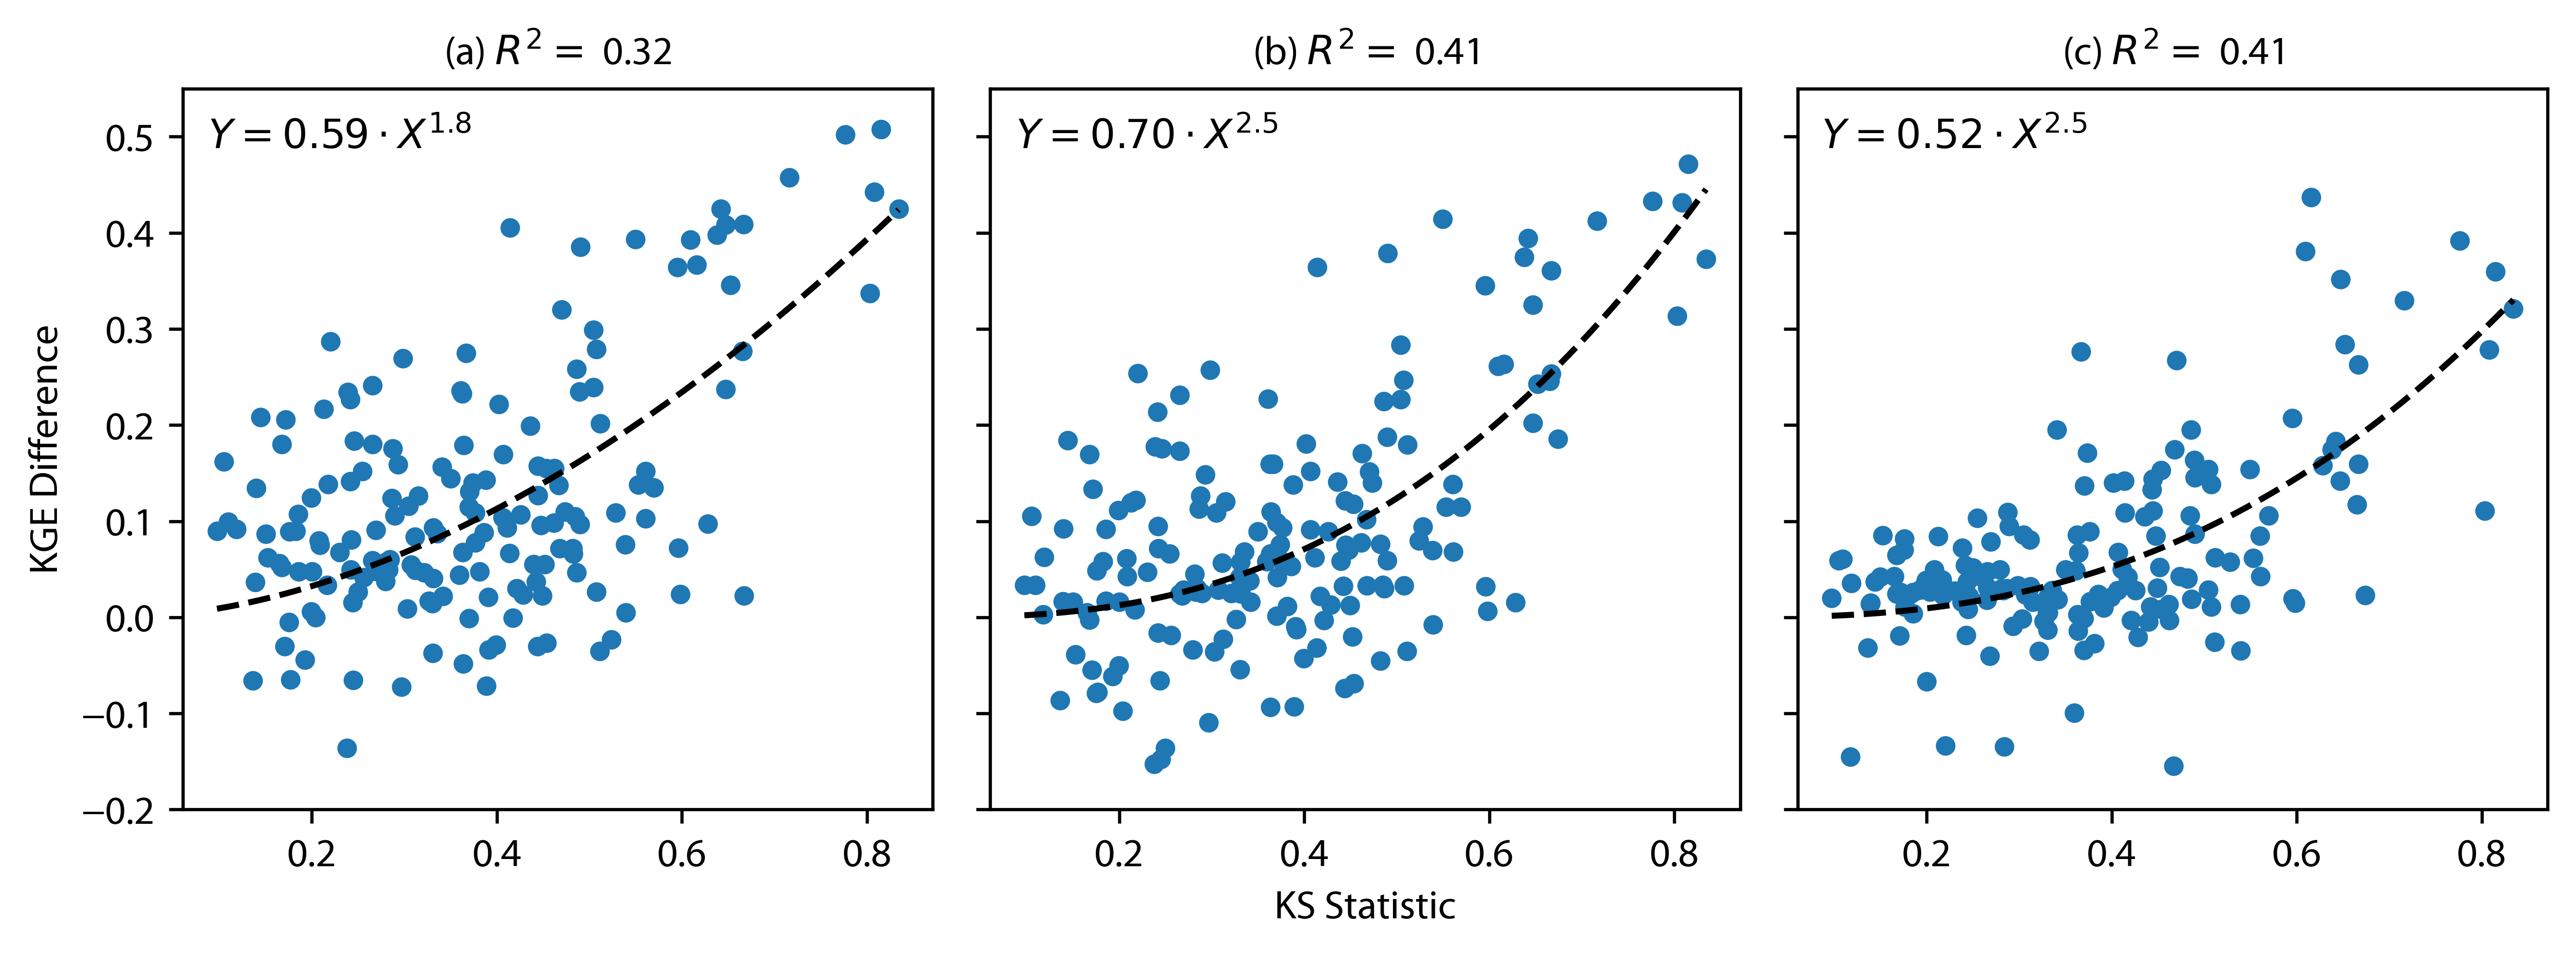

In [68]:
fig, ax = plt.subplots(1, 3, figsize = (9, 3.4),sharey=True)

tmp_x = ks_statistic.flatten()
tmp_y = kge2_bc.flatten() - kge1.flatten()

ax[0].scatter(tmp_x, tmp_y, s = 15, marker='o')
ax[0].set_ylim([-0.2, 0.55])
ax[0].set_ylabel('KGE Difference')

xmin = np.min(tmp_x)
xmax = np.max(tmp_x)
xx_v = np.linspace(xmin, xmax, 100)
# delete where tmp_y < -0.2
# drop two station-month outliers cus they are really screwing up the linear model
outlier = np.where(tmp_y < -0.2)
tmp_x = np.delete(tmp_x, outlier)
tmp_y = np.delete(tmp_y, outlier)

# expo_list = [1 + 0.1 * i for i in range(31)]
expo_ = 1.8 # thru trial and error, 1.8 is the best
lm = LinearRegression(fit_intercept = False).fit(tmp_x[:, None]**expo_, tmp_y)
yy_v = lm.predict(xx_v[:, None]**expo_)
print(lm.coef_)
ax[0].plot(xx_v, yy_v, color = 'black', linestyle = '--')

RSS = np.sum((tmp_y - lm.predict(tmp_x[:, None]**expo_))**2)
TSS = np.sum((tmp_y - np.mean(tmp_y))**2)
rsq = 1 - RSS / TSS
print([rsq, np.sqrt(rsq)])

a = lm.coef_[0]
formula_text = r"$Y = {:.2f} \cdot X^{{{:.1f}}}$".format(a, expo_)
ax[0].text(0.23, 0.5, formula_text, fontsize=10, ha='center', va='center')
ax[0].set_title('(a) $R^2=$ {:.2f}'.format(rsq), fontsize = 10)

#----------------------------------------------------------------------------------
# i am just lazy and copied the code above
tmp_x = ks_statistic.flatten()
tmp_y = kge1_bc.flatten() - kge1.flatten()

ax[1].scatter(tmp_x, tmp_y, s = 15, marker='o')
ax[1].set_ylim([-0.2, 0.55])
ax[1].set_xlabel('KS Statistic')

xmin = np.min(tmp_x)
xmax = np.max(tmp_x)
xx_v = np.linspace(xmin, xmax, 100)
# delete where tmp_y < -0.2
# drop two station-month outliers cus they are really screwing up the linear model
outlier = np.where(tmp_y < -0.2)
tmp_x = np.delete(tmp_x, outlier)
tmp_y = np.delete(tmp_y, outlier)

# expo_list = [1 + 0.1 * i for i in range(31)]
expo_ = 2.5 # thru trial and error, 2.5 is the best
lm = LinearRegression(fit_intercept = False).fit(tmp_x[:, None]**expo_, tmp_y)
yy_v = lm.predict(xx_v[:, None]**expo_)
ax[1].plot(xx_v, yy_v, color = 'black', linestyle = '--')
print(lm.coef_)

RSS = np.sum((tmp_y - lm.predict(tmp_x[:, None]**expo_))**2)
TSS = np.sum((tmp_y - np.mean(tmp_y))**2)
rsq = 1 - RSS / TSS
print([rsq, np.sqrt(rsq)])

a = lm.coef_[0]
formula_text = r"$Y = {:.2f} \cdot X^{{{:.1f}}}$".format(a, expo_)
ax[1].text(0.23, 0.5, formula_text, fontsize=10, ha='center', va='center')
ax[1].set_title('(b) $R^2=$ {:.2f}'.format(rsq), fontsize = 10)

#----------------------------------------------------------------------------------
# i am just lazy and copied the code above
tmp_x = ks_statistic.flatten()
tmp_y = kge2.flatten() - kge1.flatten()

ax[2].scatter(tmp_x, tmp_y, s = 15, marker='o')
ax[2].set_ylim([-0.2, 0.55])

xmin = np.min(tmp_x)
xmax = np.max(tmp_x)
xx_v = np.linspace(xmin, xmax, 100)
# delete where tmp_y < -0.2
# drop two station-month outliers cus they are really screwing up the linear model
outlier = np.where(tmp_y < -0.2)
tmp_x = np.delete(tmp_x, outlier)
tmp_y = np.delete(tmp_y, outlier)

# expo_list = [1 + 0.1 * i for i in range(31)]
expo_ = 2.5 # thru trial and error, 2.5 is the best
lm = LinearRegression(fit_intercept = False).fit(tmp_x[:, None]**expo_, tmp_y)
yy_v = lm.predict(xx_v[:, None]**expo_)
ax[2].plot(xx_v, yy_v, color = 'black', linestyle = '--')
print(lm.coef_)

RSS = np.sum((tmp_y - lm.predict(tmp_x[:, None]**expo_))**2)
TSS = np.sum((tmp_y - np.mean(tmp_y))**2)
rsq = 1 - RSS / TSS
print([rsq, np.sqrt(rsq)])

a = lm.coef_[0]
formula_text = r"$Y = {:.2f} \cdot X^{{{:.1f}}}$".format(a, expo_)
ax[2].text(0.23, 0.5, formula_text, fontsize=10, ha='center', va='center')
ax[2].set_title('(c) $R^2=$ {:.2f}'.format(rsq), fontsize = 10)

plt.tight_layout()

fig.savefig('figures_two_stage/KGE_diff_vs_KS.png', dpi = 600, bbox_inches = 'tight')

In [54]:
# the scatter plots of raw vs posterior mean
sta_name = pd.read_csv('data/sta_lookup_new.csv', delimiter=',', header=None)[0]
path = 'figures_two_stage/scatter_plots/'
str = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']
for i in range(12):
    xx_obs = rain_obs[i::12, :]
    xx_sim = wrf_sta[i::12, :]
    fig, ax = plt.subplots(4, 4, figsize=(12, 12), sharex=True, sharey=True)
    for j in range(14):
        ri, ci = divmod(j, 4)  # Calculate row, column index
        ax[ri, ci].scatter(xx_obs[:, j], xx_sim[:, j], color='dimgrey', marker='D', s=50, label='Raw')
        ax[ri, ci].scatter(xx_obs[:, j], r1[i::12, j], color=ipcc_orange, marker='o', s=50, label='WRF-GP')
        ax[ri, ci].scatter(xx_obs[:, j], r2[i::12, j], color=ipcc_blue, marker='^', s=50, label='WRF-GP + Kriging')
        ax[ri, ci].axline([0, 0], [1, 1], color='black', linestyle='--')
        ax[ri, ci].set_xlim(left=0)  # Set x-axis to start from 0
        ax[ri, ci].set_ylim(bottom=0)  # Set y-axis to start from 0
        tmp_kge0 = kge(xx_obs[:, j], xx_sim[:, j])
        tmp_kge1 = kge(xx_obs[:, j], r1[i::12, j])
        tmp_kge2 = kge(xx_obs[:, j], r2[i::12, j])
        ax[ri, ci].set_title('(' + str[j] + f') KGE = {tmp_kge1:.2f}, {tmp_kge2:.2f} ({tmp_kge0:.2f})')
        # Add station names inside subplots as legends
        ax[ri, ci].text(0.05, 0.95, f'{sta_name[j]}', transform=ax[ri, ci].transAxes, 
                        fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))
    for k in range(14, 16):
        ax[k // 4, k % 4].axis('off')
    ax[2, 2].tick_params(axis='x', which='both', labelbottom=True)  # Figure (k)
    ax[2, 3].tick_params(axis='x', which='both', labelbottom=True)  # Figure (l)
    # Place a single legend on the last row's leftmost subplot
    handles, labels = ax[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0.6, 0.1), fontsize = 14)

    # Add shared x and y axis labels
    fig.text(0.5, 0.01, 'Observed Rainfall [mm]', ha='center', va='center', fontsize='large')
    fig.text(0.01, 0.5, 'Estimated Rainfall [mm]', ha='center', va='center', rotation='vertical', fontsize='large')
    plt.subplots_adjust(left=0.12, right=0.9, top=0.9, bottom=0.12)  # Adjust the subplots to provide space for labels
    plt.tight_layout(pad=2)  # Increase padding to avoid overlap
    # plt.show()

    fig.savefig(f'{path}scatter_{i+1}.png', dpi=600, bbox_inches='tight')
    plt.close(fig)